<a href="https://colab.research.google.com/github/pranavkantgaur/Coursera_DL_specialization_from_scratch/blob/master/course1/week3/Planar_data_classification_with_onehidden_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the flower dataset
The utility generates the flower dataset:  
X: 2D coordibates of a point  
Y: label representing the class of that point in the flower. (Red/Blue)   
The goal of the 2-class classifier will be to assign labels to input points.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as sklearn_linearmodel
import os
np.random.seed(1)

In [0]:
# generates synthetic dataset
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

In [0]:
X, Y  = load_planar_dataset()

In [0]:
print("X.shape: ", X.shape)
print("Y.shape: ", Y.shape)

X.shape:  (2, 400)
Y.shape:  (1, 400)


## Visualize the data

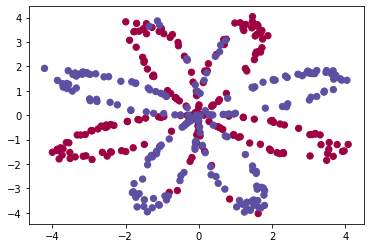

In [0]:
plt.scatter(X[0, :], X[1, :], c = Y[0, :], s = 40, cmap = plt.cm.Spectral)

## Logistic regression using sklearn

In [0]:
sklearn_classifier = sklearn_linearmodel.LogisticRegression()
sklearn_classifier.fit(X.T, np.squeeze(Y))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
from numpy import arange 

def plot_decision_boundary(model, X, Y):
  # plots decision boundary of a classifier over dataset
    # Run prediction over entire range of feature space
    # Represent predictions using color code   
    x1_min = X[0, :].min()
    x1_max = X[0, :].max()
    x2_min = X[1, :].min()
    x2_max = X[1, :].max()
    # grid dimensions
    print("range for x1: ", x1_min, x1_max)
    print("range for x2: ", x2_min, x2_max)

    # predictions for the grid
    x1 = np.arange(x1_min, x1_max, 0.1) # rows
    x1 = x1.reshape(x1.shape[0], 1)
    x2 = np.arange(x2_min, x2_max, 0.1) # columns
    x2 = x2.reshape(x2.shape[0], 1)
    y = np.zeros((x1.shape[0], x2.shape[0]))
    

    for i in range(x1.shape[0]): # rows
      for j in range(x2.shape[0]): # columns
        y[i, j] = model.predict(np.array([x1[i], x2[j]]).reshape(1, 2))
        
    # plot predictions for the grid and training data
    plt.title("Logistic regression")
    plt.xlabel("x1")
    plt.ylabel("x2")
    
    plt.contourf(np.squeeze(x2), np.squeeze(x1), 
                 y, cmap = plt.cm.Spectral)
    plt.scatter(X[0, :], X[1, :], 
                c = Y[0, :], s = 40, cmap = plt.cm.Spectral)

Average prediction error on training data:  69.08
In terms of cross entropy:  47.0 %
range for x1:  -4.211898112302497 4.078165875644617
range for x2:  -4.035124003739587 4.037643470481511


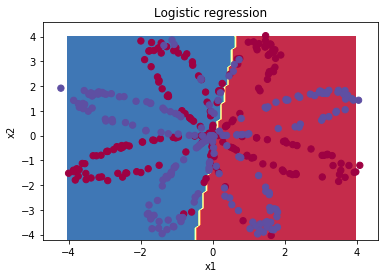

In [0]:
m = X.shape[1]
Y_pred = sklearn_classifier.predict(X.T).reshape(m ,1)
print("Average prediction error on training data: ", np.mean(np.abs(np.squeeze(Y) - Y_pred)))  
print("In terms of cross entropy: ", float((np.dot(Y, Y_pred) + np.dot(1-Y, 1 - Y_pred))) * 100 / m , "%" )
# plot the decision boundary for this classifier
plot_decision_boundary(sklearn_classifier, X, Y)

## Using a single hidden layer NN

In [0]:
def sigmoid(z):
  sig = 1 / (1 + np.exp(-z))
  return sig

In [116]:
a = np.array([1, 2, 3])
b = np.power(a , 2)
print(b)

[1 4 9]


In [0]:
class PlanarDataClassifier(object):
  def __init__(self, n_hidden_units):
    # hyperparameters
    self.n_hidden_units = n_hidden_units # len(self.n_hidden_units = number of layers)
    self.n_epochs = 0
    self.lr = 0
    # parameters
    self.w1 = 0
    self.b1 = 0
    self.w2 = 0
    self.b2 = 0
  
  def initialize_parameters(self, feature_size):
    np.random.seed(2)
    self.w1 = np.random.randn(self.n_hidden_units[0], feature_size) * 0.01
    self.b1 = np.zeros((self.n_hidden_units[0], 1))
    self.w2 = np.random.randn(self.n_hidden_units[1], self.n_hidden_units[0]) * 0.01
    self.b2 = np.zeros((self.n_hidden_units[1], 1))

  def forward(self, X):
    
    z1 = np.dot(self.w1, X) + self.b1
    a1 = np.tanh(z1)
    z2 = np.dot(self.w2, a1) + self.b2
    a2 = sigmoid(z2) # 1 X m (one output for each m samples)
    assert(a2.shape == (self.n_hidden_units[1], X.shape[1]))
    assert(a1.shape == (self.n_hidden_units[0], X.shape[1]))

    return a1, a2

  def backward(self, A1, A2, X, Y):
    
    dz2 = A2 - Y # n_hidden_units[1], X.shape[1]
    
    dw2 = np.dot(dz2, A1.T) / m # n_hidden_units[1] X n_hidden_units[0] 
    assert(dw2.shape == self.w2.shape)
    
    db2 = np.sum(dz2, axis=1, keepdims=True) / m # 1 X 1
    
    dz1 = np.dot(self.w2.T, dz2) * (1 - np.power(A1, 2))

    dw1 = np.dot(dz1, X.T) / m
    assert(dw1.shape == self.w1.shape)
    
    db1 = np.sum(dz1, axis = 1, keepdims=True) / m
        
    return dw1, db1, dw2, db2

  def update_parameters(self, dw1, db1, dw2, db2):
    #a = self.w1
    self.w1 = self.w1 - self.lr * dw1
    self.b1 = self.b1 - self.lr * db1
    self.w2 = self.w2 - self.lr * dw2
    self.b2 = self.b2 - self.lr * db2
    #print("Diff: ", a - self.w1)


  def compute_cost(self, A, Y):
    cost = - float((np.dot(Y, np.log(A).T) + np.dot(1-Y, np.log(1-A).T))) / Y.shape[1]
    return cost

  def train(self, X, Y,n_epochs, lr):
    
    self.initialize_parameters(X.shape[0]) 
    
    self.lr = lr
    
    self.n_epochs = n_epochs

    for i in range(n_epochs):
      A1, A2  = self.forward(X)
      dw1, db1, dw2, db2 = self.backward(A1, A2, X, Y)     
      self.update_parameters(dw1, db1, dw2, db2)
      cost = self.compute_cost(A2, Y)
      if (i % 1000 == 0):
        print("Cost at epoch: ", i, "is: ", cost)
    # save final parameters
    try:  
      os.mkdir("params")  
    except OSError as error:  
      print(error)   
    np.save("params/w1.npy", self.w1)    
    np.save("params/b1.npy", self.b1)
    np.save("params/w2.npy", self.w2)
    np.save("params/b2.npy", self.b2)

  
  def predict(self, X_test):
    self.w1 = np.load("params/w1.npy")         
    self.b1 = np.load("params/b1.npy")
    self.w2 = np.load("params/w2.npy")
    self.b2 = np.load("params/b2.npy")
    _, A_predict = self.forward(X_test)
    Y_predict = (A_predict > 0.5)
    return Y_predict

  def evaluate(self, X_test, Y_test):
    self.w1 = np.load("params/w1.npy")         
    self.b1 = np.load("params/b1.npy")
    self.w2 = np.load("params/w2.npy")
    self.b2 = np.load("params/b2.npy")
    _, A_predict = self.forward(X_test)
    Y_predict = (A_predict > 0.5)
    accuracy = 100 * float(np.dot(Y_test, Y_predict.T) + 
                           np.dot(1-Y_test, (1-Y_predict).T)) / Y.shape[1]
    print("Accuracy of trained model: ", accuracy)


In [0]:
planar_classifier = PlanarDataClassifier(n_hidden_units = [4, 1]) # 2 layer network

In [110]:
planar_classifier.train(X, Y, n_epochs = 10000, lr = 1.2)

Cost at epoch:  0 is:  0.6930480201239824
Cost at epoch:  1000 is:  0.28808329356901846
Cost at epoch:  2000 is:  0.25438549407324557
Cost at epoch:  3000 is:  0.23386415038952207
Cost at epoch:  4000 is:  0.2267924874485401
Cost at epoch:  5000 is:  0.2226442754929902
Cost at epoch:  6000 is:  0.21973140404281322
Cost at epoch:  7000 is:  0.217503654051313
Cost at epoch:  8000 is:  0.21955557896173938
Cost at epoch:  9000 is:  0.21858487275645275


In [111]:
planar_classifier.evaluate(X, Y) # effectively it is train accuracy

Accuracy of trained model:  90.75
